# Non-Hermitian Persistent Current Transport
## SNS Junctions
Authors: Pei-Xin Shen, Zhide Lu, Jose L. Lado, and Mircea Trif

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dmrgpy import fermionchain
from scipy.interpolate import interp1d

In [2]:
t = -1  # hopping strength
gamma = 1  # superconducting gap
g = -1.1  # chemical potential
kappa = 1*t  # internal junction coupling strength
kappa_reservoir_left = 0.4*t  # left reservoir coupling strength
kappa_reservoir_right = 0.4*t  # right reservoir coupling strength
N_left = 4
N_middle = 4
N_right = 4
N_reservoir_left = 101
N_reservoir_right = 101
N_total = N_reservoir_left + N_left + N_middle + N_right + N_reservoir_right

fc = fermionchain.Fermionic_Chain(N_total) # create the fermionic chain

t_site = [t for _ in range(N_total-1)]
# tune the coupling strength at the junction interface
t_site[N_reservoir_left + N_left-1] = t_site[N_reservoir_left + N_left +
                                             N_middle - 1] = kappa
if N_reservoir_left > 0:
    t_site[N_reservoir_left-1] = kappa_reservoir_left
if N_reservoir_right > 0:
    t_site[N_total - N_reservoir_right - 1] = kappa_reservoir_right

gamma_site = [0 for _ in range(N_total-1)]
# tune the gap in the left superconductor
for i in range(N_reservoir_left, N_reservoir_left + N_left - 1):
    gamma_site[i] = gamma
# tune the gap in the right superconductor
for i in range(N_total - N_reservoir_right - N_right, N_total - N_reservoir_right - 1):
    gamma_site[i] = gamma
# global chemical potential
g_site = [g for _ in range(N_total)]


def model_Hamiltonian(phi, delta=0):
    # superconducting phase
    phi_site = [phi if N_reservoir_left + N_left + N_middle <= i <
                N_total - N_reservoir_right - 1 else 0 for i in range(N_total-1)]
    # global many-body interactions
    # delta_site = [delta for _ in range(N_total-1)]
    # SNS part many-body interactions
    # delta_site = [delta if N_reservoir_left - 1 <= i <= N_reservoir_left + N_left + N_middle + N_right - 1 else 0 for i in range(N_total-1)]
    # normal part many-body interactions
    delta_site = [delta if N_reservoir_left + N_left-1 <= i <=  N_reservoir_left + N_left + N_middle - 1 else 0 for i in range(N_total-1)]
    h = 0  # initialize Hamiltonian
    for i in range(N_total-1):
        # create hopping terms
        h = h + t_site[i]*fc.Cdag[i]*fc.C[i+1]
        # create superconducting terms
        h = h + gamma_site[i]*np.exp(-1j*phi_site[i])*fc.Cdag[i]*fc.Cdag[i+1]
    # make the Hamiltonian Hermitian
    h = h + h.get_dagger()
    for i in range(N_total-1):
        # create NN-type many-body interactions
        # h = h + delta_site[i]*fc.N[i]*fc.N[i+1]
        # create ZZ-type many-body interactions
        h = h = h + delta_site[i]*(fc.N[i] - 1/2)*(fc.N[i+1] - 1/2)
    for i in range(N_total):
        # on-site chemical potential
        h = h + g_site[i]*(fc.Cdag[i]*fc.C[i] - 1/2)
    return h
def energy_current(phi, delta=0, mode="DMRG", i = N_reservoir_left + N_left):
    h = model_Hamiltonian(phi, delta)
    fc.set_hamiltonian(h)
    return np.array([fc.gs_energy(mode), t*((-1j)*fc.vev(fc.Cdag[i]*fc.C[i+1]-fc.Cdag[i+1]*fc.C[i], mode)).real])

In [3]:
phi_int = np.pi
phi_min = np.pi - phi_int
phi_max = np.pi + phi_int
phi_num = 11
phi_list = np.linspace(phi_min, phi_max, phi_num)
print(phi_list)

[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 6.28318531]


In [4]:
delta = 0
[eigen_values_free, current_values_free] = np.array(
    [energy_current(phi, delta) for phi in phi_list]).T
print(eigen_values_free)
print(current_values_free)

[-158.45494564 -158.45170271 -158.4406438  -158.42279055 -158.39992129
 -158.38341236 -158.39992429 -158.42279054 -158.4406438  -158.4517027
 -158.45522081]
[-0.          0.02368604  0.04646251  0.06642959  0.07580111 -0.
 -0.0757702  -0.06642928 -0.04646248 -0.02368605 -0.        ]


In [5]:
delta = 1
[eigen_values_weak, current_values_weak] = np.array(
    [energy_current(phi, delta) for phi in phi_list]).T
print(eigen_values_weak)
print(current_values_weak)

[-158.75885779 -158.75495442 -158.74361056 -158.7258227  -158.70495277
 -158.69287795 -158.70493911 -158.72581461 -158.743612   -158.75495423
 -158.75885195]
[-0.          0.02448053  0.04732137  0.06483344  0.06358112 -0.
 -0.06361497 -0.06485229 -0.0473182  -0.02448099 -0.        ]


In [6]:
delta = 8
[eigen_values_strong, current_values_strong] = np.array(
    [energy_current(phi, delta) for phi in phi_list]).T
print(eigen_values_strong)
print(current_values_strong)

[-164.56220476 -164.5617542  -164.56055675 -164.55904072 -164.55778547
 -164.55730047 -164.55778548 -164.55904073 -164.56055678 -164.56175419
 -164.56220477]
[-0.          0.00278782  0.00460891  0.00473226  0.00298275 -0.
 -0.0029827  -0.00473217 -0.00460902 -0.00278782 -0.        ]


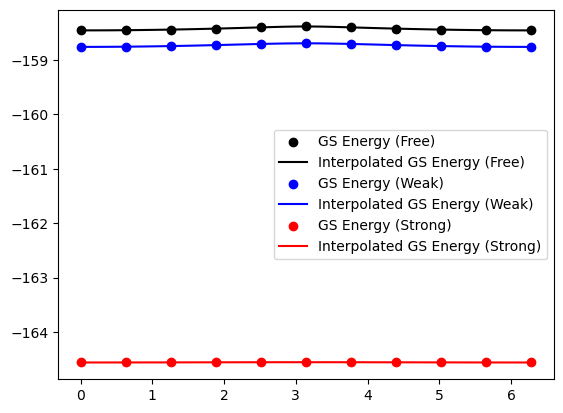

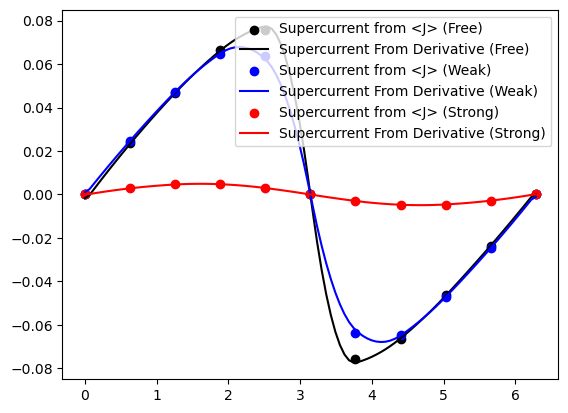

In [7]:
# Create an interpolating function (cubic spline)
interp_GS_free = interp1d(phi_list, eigen_values_free, kind='cubic')
interp_GS_weak = interp1d(phi_list, eigen_values_weak, kind='cubic')
interp_GS_strong = interp1d(phi_list, eigen_values_strong, kind='cubic')

# Generate data points for interpolation and derivative calculation
phi_interp = np.linspace(phi_list.min(), phi_list.max(), 100)
GS_free_interp = interp_GS_free(phi_interp)
GS_weak_interp = interp_GS_weak(phi_interp)
GS_strong_interp = interp_GS_strong(phi_interp)

# Calculate the derivative using NumPy's gradient function
GS_free_derivative = np.gradient(GS_free_interp, phi_interp)
GS_weak_derivative = np.gradient(GS_weak_interp, phi_interp)
GS_strong_derivative = np.gradient(GS_strong_interp, phi_interp)

# Plot the original data, interpolated function, and the derivative

plt.scatter(phi_list, eigen_values_free, label='GS Energy (Free)', color='black')
plt.plot(phi_interp, GS_free_interp, label='Interpolated GS Energy (Free)', color='black')
plt.scatter(phi_list, eigen_values_weak, label='GS Energy (Weak)', color='blue')
plt.plot(phi_interp, GS_weak_interp, label='Interpolated GS Energy (Weak)', color='blue')
plt.scatter(phi_list, eigen_values_strong, label='GS Energy (Strong)', color='red')
plt.plot(phi_interp, GS_strong_interp, label='Interpolated GS Energy (Strong)', color='red')
plt.legend()
plt.show()

plt.scatter(phi_list, current_values_free, label='Supercurrent from <J> (Free)', color='black')
plt.plot(phi_interp, 2*GS_free_derivative, label='Supercurrent From Derivative (Free)', color='black')
plt.scatter(phi_list, current_values_weak, label='Supercurrent from <J> (Weak)', color='blue')
plt.plot(phi_interp, 2*GS_weak_derivative, label='Supercurrent From Derivative (Weak)', color='blue')
plt.scatter(phi_list, current_values_strong, label='Supercurrent from <J> (Strong)', color='red')
plt.plot(phi_interp, 2*GS_strong_derivative, label='Supercurrent From Derivative (Strong)', color='red')
plt.legend()
plt.show()

In [8]:
import csv
with open('freeSNS.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([eigen_values_free, current_values_free])
with open('weakSNS.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([eigen_values_weak, current_values_weak])
with open('strongSNS.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([eigen_values_strong, current_values_strong])
